In [1]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy as sp
import faraway.utils

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [85]:
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(42)

def f(X):
    pol = PolynomialFeatures(3).fit_transform(X.reshape(-1, 1))
    betas = np.arange(pol.shape[1])
    return pol @ betas

X_train = np.random.normal(size=100).reshape(-1, 1)
X_val = np.random.normal(size=100).reshape(-1, 1)

y_train = f(X_train) + np.random.normal(scale=5, size=100)
y_val = f(X_val) + np.random.normal(scale=5, size=100)

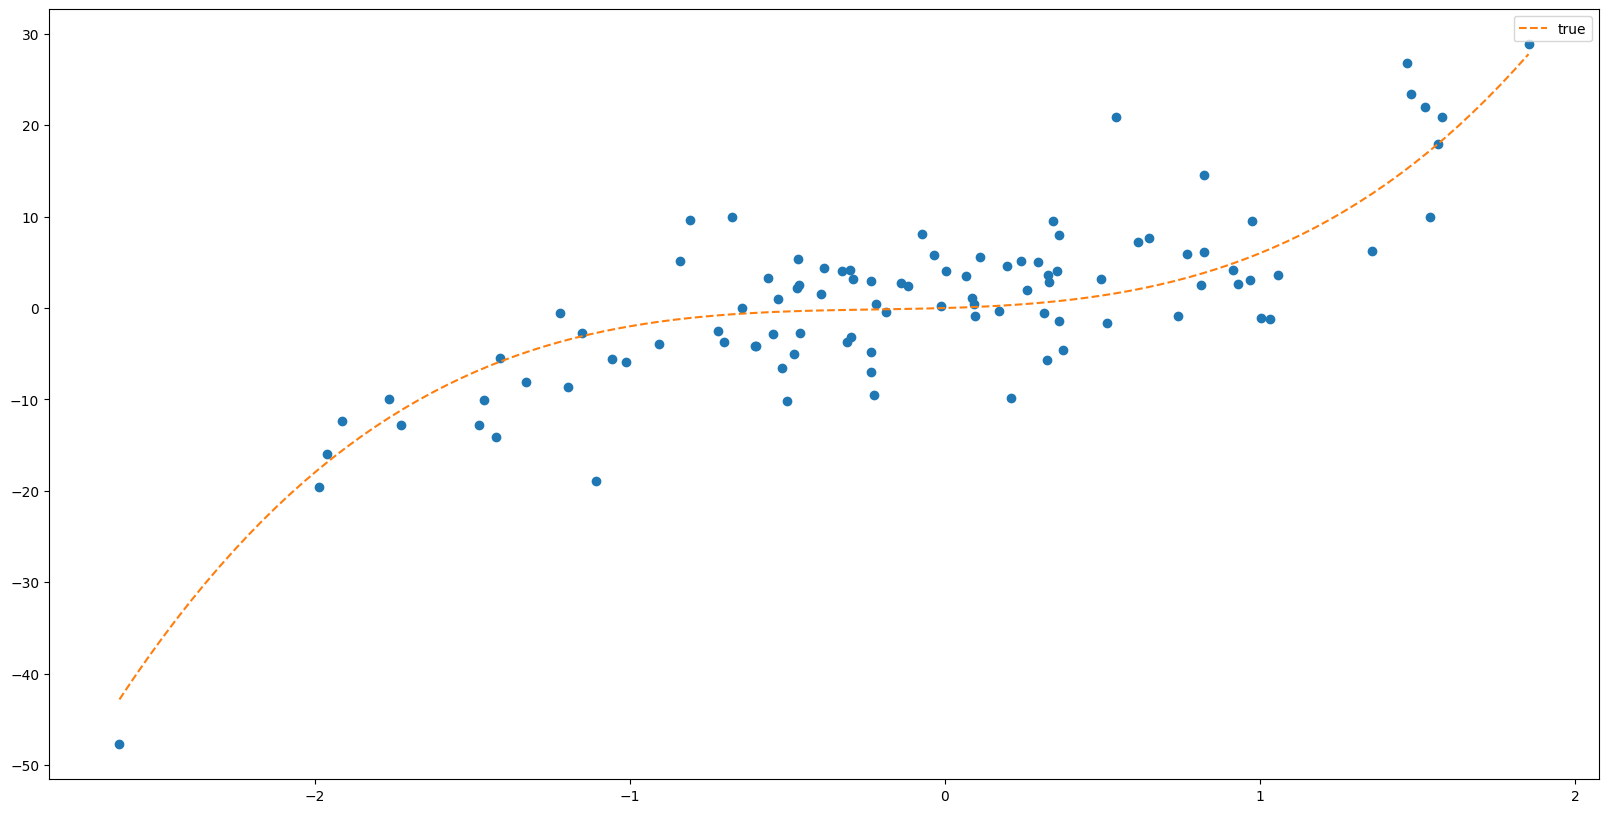

In [40]:
plt.scatter(X_train, y_train)
ix = np.linspace(X_train.min(), X_train.max(), num=100)
plt.plot(ix, f(ix), label="true", color="tab:orange", ls='--')
plt.gca().legend()

We are trying to fit a polynomial to this data. </br>
For this end, we'll use best subset selection on the train set.

In [43]:
pol_feat = PolynomialFeatures(10, include_bias=False).fit(X_train)
X_train_tr = pd.DataFrame(
    pol_feat.transform(X_train), 
    columns=pol_feat.get_feature_names_out()
)
X_train_tr

,x0,x0^2,x0^3,x0^4,x0^5,x0^6,x0^7,x0^8,x0^9,x0^10
0,0.496714,0.246725,1.225518e-01,6.087320e-02,3.023658e-02,1.501894e-02,7.460119e-03,3.705547e-03,1.840597e-03,9.142508e-04
1,-0.138264,0.019117,-2.643201e-03,3.654603e-04,-5.053012e-05,6.986511e-06,-9.659851e-07,1.335613e-07,-1.846675e-08,2.553293e-09
2,0.647689,0.419500,2.717056e-01,1.759806e-01,1.139806e-01,7.382395e-02,4.781493e-02,3.096918e-02,2.005838e-02,1.299158e-02
3,1.523030,2.319620,3.532850e+00,5.380637e+00,8.194870e+00,1.248103e+01,1.900898e+01,2.895125e+01,4.409362e+01,6.715590e+01
4,-0.234153,0.054828,-1.283812e-02,3.006088e-03,-7.038856e-04,1.648172e-04,-3.859250e-05,9.036565e-06,-2.115942e-06,4.954550e-07
...,...,...,...,...,...,...,...,...,...,...
95,-1.463515,2.141876,-3.134668e+00,4.587633e+00,-6.714069e+00,9.826141e+00,-1.438070e+01,2.104637e+01,-3.080168e+01,4.507873e+01
96,0.296120,0.087687,2.596596e-02,7.689048e-03,2.276883e-03,6.742313e-04,1.996535e-04,5.912146e-05,1.750706e-05,5.184197e-06
97,0.261055,0.068150,1.779088e-02,4.644403e-03,1.212446e-03,3.165154e-04,8.262801e-05,2.157048e-05,5.631087e-06,1.470025e-06
98,0.005113,0.000026,1.337038e-07,6.836886e-10,3.496012e-12,1.787670e-14,9.141175e-17,4.674300e-19,2.390183e-21,1.222210e-23


In [46]:
import itertools
pcols = list(X_train_tr.columns)

rss = np.empty(len(pcols) + 1)
# rss for 0-predictor model
# only one parameter \beta_0
# which is estimated by y.bar
rss[0] = np. sum(
    (y_train - np.mean(y_train))**2
)
selvar = ['None']

for k in range(1, len(pcols)+1):
    RSS = {}
    for variables in itertools.combinations(pcols, k):
        predictors = X_train_tr.loc[:, list(variables)]
        predictors['Intercept'] = 1
        res = sm.OLS(y_train, predictors).fit()
        RSS[variables] = res.ssr
    rss[k] = min(RSS.values())
    selvar.append(min(RSS, key=RSS.get))
    
min_rss_models = list(zip(selvar, rss.round(3)))
min_rss_models

[('None', 10205.768),
 (('x0^3',), 3256.467),
 (('x0^3', 'x0^4'), 2861.602),
 (('x0', 'x0^5', 'x0^6'), 2756.874),
 (('x0', 'x0^3', 'x0^6', 'x0^10'), 2682.209),
 (('x0', 'x0^5', 'x0^8', 'x0^9', 'x0^10'), 2654.781),
 (('x0', 'x0^4', 'x0^6', 'x0^7', 'x0^8', 'x0^9'), 2614.019),
 (('x0', 'x0^2', 'x0^4', 'x0^6', 'x0^7', 'x0^8', 'x0^9'), 2572.478),
 (('x0', 'x0^2', 'x0^4', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10'), 2545.132),
 (('x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^10'),
  2527.115),
 (('x0',
   'x0^2',
   'x0^3',
   'x0^4',
   'x0^5',
   'x0^6',
   'x0^7',
   'x0^8',
   'x0^9',
   'x0^10'),
  2523.598)]

In [48]:
n = X_train.shape[0]
aic = n * np.log(rss/n) + 2*np.arange(1, len(rss)+1)

rsq = 1 - rss/rss[0]
rsq_adj = 1 - (1-rsq)*(n-1)/(n-np.arange(rss.shape[0]))

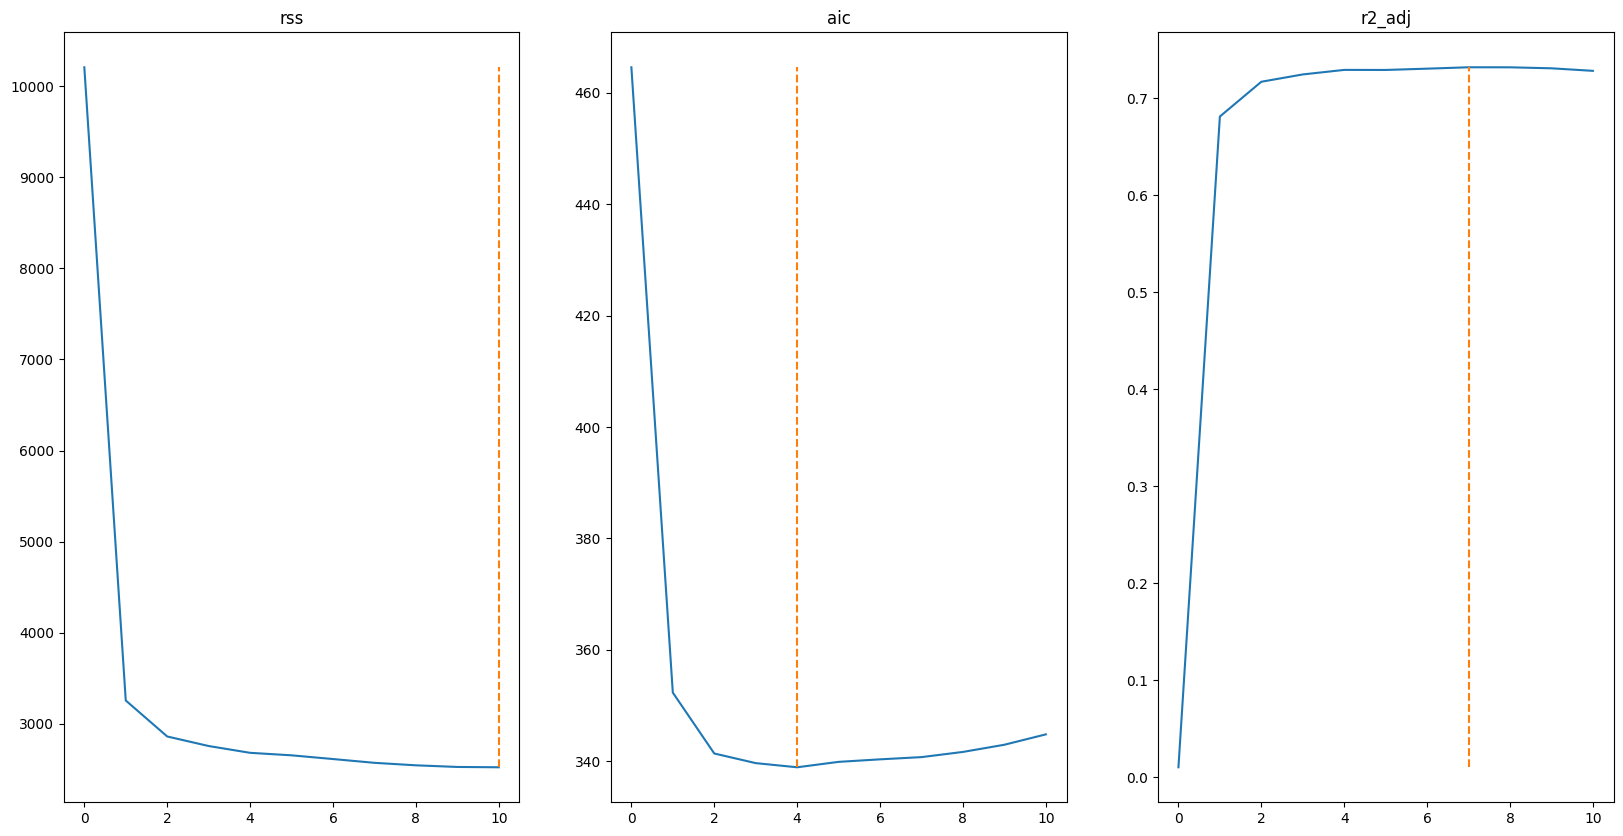

In [84]:
fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

for ax, metric_arr, metric_name in zip(axs, [rss, aic, rsq_adj], ["rss", "aic", "r2_adj"]):
    ax.plot(range(len(metric_arr)), metric_arr)
    if metric_name=="r2_adj":
        ix = [metric_arr.argmax(), metric_arr.argmax()]
    else:
        ix = [metric_arr.argmin(), metric_arr.argmin()]
    ax.plot(
        ix, 
        [metric_arr.min(), metric_arr.max()],
        ls='--'
    )
    ax.set_title(metric_name)

In [79]:
selected_vars = list(min_rss_models[4][0])
lmod = sm.OLS(y_train, X_train_tr[selected_vars]).fit()
selected_vars

['x0', 'x0^3', 'x0^6', 'x0^10']

PolynomialFeatures(degree=10, include_bias=False)

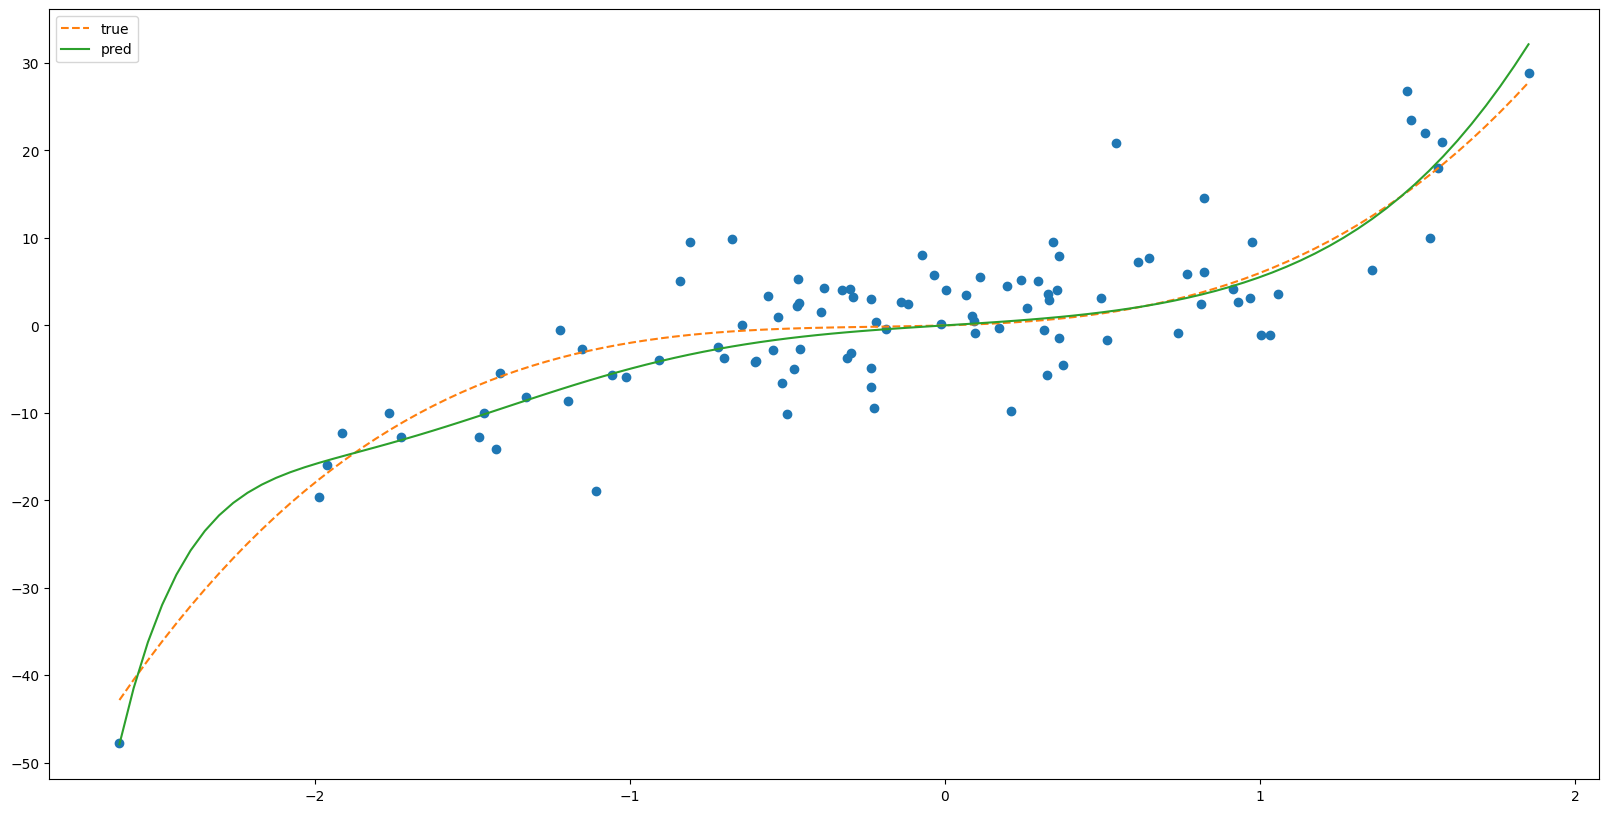

In [86]:
X_train_tr[selected_vars]
plt.scatter(X_train, y_train)
ix = np.linspace(X_train.min(), X_train.max(), num=100)

to_pred = pd.DataFrame(
    pol_feat.transform(ix.reshape(-1, 1)),
    columns=pol_feat.get_feature_names_out()
)[selected_vars]
pred = lmod.predict(to_pred)

plt.plot(ix, f(ix), label="true", color="tab:orange", ls='--')
plt.plot(ix, pred, label="pred", color="tab:green")
plt.gca().legend()

In [90]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

sfs = SequentialFeatureSelector(
    LinearRegression(), 
    n_features_to_select="auto",
    tol=0.1,
    scoring="r2"
)
sfs.fit_transform(X_train_tr, y_train)


array([[ 1.22551774e-01],
       [-2.64320099e-03],
       [ 2.71705628e-01],
       [ 3.53285043e+00],
       [-1.28381151e-02],
       [-1.28354148e-02],
       [ 3.93841955e+00],
       [ 4.51985337e-01],
       [-1.03475065e-01],
       [ 1.59714160e-01],
       [-9.95217106e-02],
       [-1.01018741e-01],
       [ 1.41658604e-02],
       [-7.00383267e+00],
       [-5.13221966e+00],
       [-1.77776911e-01],
       [-1.03898939e+00],
       [ 3.10323597e-02],
       [-7.48672862e-01],
       [-2.81698343e+00],
       [ 3.14839869e+00],
       [-1.15089329e-02],
       [ 3.07932559e-04],
       [-2.89210688e+00],
       [-1.61329209e-01],
       [ 1.36477168e-03],
       [-1.52482043e+00],
       [ 5.30294000e-02],
       [-2.16690520e-01],
       [-2.48188338e-02],
       [-2.17848389e-01],
       [ 6.35504508e+00],
       [-2.45885794e-06],
       [-1.18331665e+00],
       [ 5.56517546e-01],
       [-1.81961767e+00],
       [ 9.11146574e-03],
       [-7.52573488e+00],
       [-2.3

In [89]:
dir(sfs)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_get_best_new_feature_score',
 '_get_param_names',
 '_get_support_mask',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_transform',
 '_validate_data',
 'cv',
 'direction',
 'estimator',
 'feature_names_in_',
 'fit',
 'fit_transform',
 'get_feature_names_out',
 'get_params',
 'get_support',
 'inverse_transform',
 'n_features_in_',
 'n_features_to_select',
 'n_features_to_select_',
 'n_jobs',
 'scoring',
 'set_params',
 'support_',
 'tol'